# INF581 Lab4: Dynamic Programming - Value Iteration and Policy Iteration

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/main/logo.jpg" style="float: left; width: 15%" />

[INF581-2024](https://moodle.polytechnique.fr/course/view.php?id=17108) Lab session #4

2019-2024 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab4_rl1_dynamic_programming.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab4_rl1_dynamic_programming.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab4_rl1_dynamic_programming.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab4_rl1_dynamic_programming.ipynb)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning like *Dynamic Programming*, *Bellman's Principle of Optimality* and *Bellman equations*.

You will implement and test the two main dynamic programming algorithms (*Value Iteration* and *Policy Iteration*) in this Python notebook.

You can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab4_rl1_dynamic_programming.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab4_rl1_dynamic_programming.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab4_rl1_dynamic_programming.ipynb

If you work with Google Colab or MyBinder, remember to save or download your work regularly or you may lose it!

**Notice**: Here we assume that the reward only depends on the state: $r(\boldsymbol{s}) \equiv \mathcal{R}(\boldsymbol{s}, \boldsymbol{a}, \boldsymbol{s}')$.

## Task 0: Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [25]:
## EXTRACT ID

info = {
        'Email' : 'yannis.kedadry@polytechnique.edu',
        'Alias' : 'yKedadry', # (change this in case you want to identify yourself on the leaderboard)
}

## Python requirements

This notebook requires the following Python libraries: *Gymnasium*, NumPy, Pandas and Seaborn.

### If you use Google Colab

Execute the next cell to install required libraries.

In [26]:
colab_requirements = [
    "gymnasium",
    "numpy",
    "pandas",
    "seaborn"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

### If you use MyBinder

Required libraries are already installed, you have nothing to do.

### If you have downloaded the notebook on your computer and execute it in your own Python environment

Uncomment and execute the following cell to install required packages in your local environment (remove only the `#` not the `!`).

In [27]:
#!pip install gymnasium numpy pandas seaborn

## Import required libraries

In [28]:
# EXTRACT Imports

import math
import gymnasium as gym
import numpy as np
import copy
import pandas as pd

from typing import List, Optional, Tuple, Union, Callable

In [29]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

In [30]:
gym.__version__

'0.29.1'

In [31]:
sns.set_context("talk")

In [32]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Backward Induction

*Backward Induction* is a basic *Dynamic Programming* method **[BELLMAN57]**.
Like other Dynamic Programming algorithms, it uses the *Bellman's
Principle of Optimality* **[BELLMAN57]** for accelerating computation (compared
to an exhaustive search). It can be applied to problems that exhibit a compatible structure, i.e., a problem that has *overlapping subproblems* or a problem having an *optimal substructure* **[BELLMAN57]**.
Actually, this acceleration is obtained by breaking problems down into simpler subproblems in such a manner
that redundant computations are avoided by storing results.
When applicable, the method takes far less time than naïve methods that don't take advantage of the subproblem overlap (like depth-first search).

*Backward Induction* computes non-stationary policies: a new policy is computed for each time step.
Thus the number of time steps used to solve the problem is set in advance.
*Backward Induction* algorithms solve Sequential Decision Making problems defined with
discrete actions and state spaces.

The *value* (or *utility*) $V^*$ for each state $\boldsymbol{s}$ at the latest time step $T$ is
$$
V^*_T(\boldsymbol{s}) = r(\boldsymbol{s})
$$
where $r$ is the immediate reward function.

The best expected value $V^*$ for each state $\boldsymbol{s}$ at the $t^{\text{th}}$ time step is
$$
V^*_t(\boldsymbol{s}) = r(\boldsymbol{s}) + \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V^*_{t+1}(\boldsymbol{s}') \right]  \tag{1}
$$
and the $t^{\text{th}}$ optimal action (or decision) $d^*_t(\boldsymbol{s})$ among the set of
possible actions $\mathcal{A}$ is
$$
d^*_t(\boldsymbol{s}) = \arg\max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V^*_{t+1}(\boldsymbol{s}') \right]  \tag{2}
$$
where $T$ is the transition function.

The main idea is to compute the expected value of each state
(Eq. 1) and then to use it to select the
best action for any given state (Eq. 2).

Eq. 1 cannot be solved analytically because
the system of equations to compute $V$ contains non-linear terms (due to the
"max" operator).
As an alternative, Eq. 1
is usually computed using Dynamic Programming method, as described in algorithm 1.

___
### Algorithm 1: Backward Induction

**Input**:<br>
$\quad$ $mdp = \langle \mathcal{S}, \mathcal{A}, T, r \rangle$, a Markov Decision Process <br>
$\quad$ $T$, the resolution horizon (i.e. the number of time steps) <br>
**Local variables**: <br>
$\quad$ $V^*_t ~~ \forall t \in \{1, ..., T\}$, value array (expected global reward following the optimal policy for states in $\mathcal{S}$) <br>
<br>
$V^*_T[\boldsymbol{s}] \leftarrow r(\boldsymbol{s}) ~~ \forall \boldsymbol{s} \in \mathcal{S}$ <br>
**for all** $t \in \{T-1, T-2, ..., 1\}$ **do** <br>
$\quad$ **for all** $\boldsymbol{s} \in \mathcal{S}$ **do** <br>
$\quad\quad$ **if** $\boldsymbol{s}$ is a final state **then** <br>
$\quad\quad\quad$ $\displaystyle V^*_t[\boldsymbol{s}] \leftarrow r(\boldsymbol{s})$ <br>
$\quad\quad$ **else** <br>
$\quad\quad\quad$ $\displaystyle V^*_t[\boldsymbol{s}] \leftarrow r(\boldsymbol{s}) + \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V^*_{t+1}[\boldsymbol{s}'] \right]$ <br>
$\quad\quad$ **end if** <br>
$\quad$ **end for** <br>
**end for** <br>
<br>
**return** $V^*_t ~~ \forall t \in \{1, ..., T\}$
___

## Value Iteration

*Value Iteration* **[BELLMAN57]** is one of the most famous Dynamic Programming algorithm to compute the optimal policy for a Markov Decision Process (MDP).
Similarly to Backward Induction, the
main idea implemented by Value Iteration is to compute the best expected value of each state and then to use
these values to select the best action from any given state.

The main difference with the Backward Induction algorithm is that Value Iteration
is used to compute stationary policies.
Indeed, the same resulting policy is used for each time step and thus there is
no assumption about the number of time steps to consider for the solution.

The expected value $V^{\pi}$ for each state $\boldsymbol{s}$ when the agent follows a
given (stationary) policy $\pi$ is
$$
V^{\pi}(\boldsymbol{s}) = E \left[ \sum^{\infty}_{t=0} \gamma^t r(\boldsymbol{s}_t) | \pi, \boldsymbol{s}_0 = \boldsymbol{s} \right]
$$

The optimal (stationary) policy $\pi^*$ is defined using the best expected value $V^{\pi^*}$ and using the principle of *Maximum Expected Utility* as follows
$$
\pi^*(\boldsymbol{s}) = \arg\max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V^{\pi^*}(\boldsymbol{s}') \right]
$$

Eq. 3 is commonly called *Bellman equation*; it gives the best
value we can expect for any given
state (assuming the optimal policy $\pi^*$ is
followed). There are $|\mathcal{S}|$ Bellman equations, one for each state.
As for the Backward Induction method,
this system of equations cannot be solved analytically because
Bellman equations contain non-linear terms (due to the
"max" operator).  As an alternative, Eq. 3
can be computed iteratively using Value Iteration, a Dynamic Programming method
described in Algorithm 2.

\begin{equation}
    V(\boldsymbol{s}) := V^{\pi^*}(\boldsymbol{s}) = \left\{
    \begin{array}{l l}
        r(\boldsymbol{s})                                                                                                                                 & \quad \text{if $\boldsymbol{s}$ is a final state} \\
        \displaystyle r(\boldsymbol{s}) + \gamma \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V(\boldsymbol{s}') \right]    & \quad \text{otherwise}\\
    \end{array} \right.
\end{equation}

Equation 4 -- called *Bellman update* -- is
used in the iterative method described in Algorithm 2, to update $V$ at each iteration.

\begin{equation}
    V_{i+1}(\boldsymbol{s}) \leftarrow \left\{
    \begin{array}{l l}
        r(\boldsymbol{s})                                                                                                                                   & \quad \text{if $\boldsymbol{s}$ is a final state} \\
        \displaystyle r(\boldsymbol{s}) + \gamma \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V_i(\boldsymbol{s}') \right]    & \quad \text{otherwise}\\
    \end{array} \right.
    \tag{4}
\end{equation}

___
### Algorithm 2: Value Iteration

**Input**:<br>
$\quad$ $mdp = \langle \mathcal{S}, \mathcal{A}, P, r \rangle$, a Markov Decision Process <br>
$\quad$ $\gamma$, the discount factor <br>
$\quad$ $\epsilon$, the stopping criteria: the algorithm is stopped if the largest update in an iteration is lower than $\epsilon$ <br>
**Local variables**: <br>
$\quad$ $V, V'$, old and new estimated value array (estimation of the expected global reward following the optimal policy for all states in $\mathcal{S}$), initially zero <br>
$\quad$ $\delta$, the largest change in the value array in an iteration <br>
<br>
**repeat** <br>
$\quad$ $V \leftarrow V'$ <br>
$\quad$ $\delta \leftarrow 0$ <br>
$\quad$ **for all** $\boldsymbol{s} \in \mathcal{S}$ **do** <br>
$\quad\quad$ **if** $\boldsymbol{s}$ is a final state **then** <br>
$\quad\quad\quad$ $\displaystyle V'[\boldsymbol{s}] \leftarrow r[\boldsymbol{s}]$ <br>
$\quad\quad$ **else** <br>
$\quad\quad\quad$ $\displaystyle V'[\boldsymbol{s}] \leftarrow r[\boldsymbol{s}] + \gamma \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V[\boldsymbol{s}'] \right]$ <br>
$\quad\quad$ **end if** <br>
$\quad\quad$ **if** $|V'[\boldsymbol{s}] - V[\boldsymbol{s}]| > \delta$ **then** <br>
$\quad\quad\quad$ $\delta \leftarrow |V'[\boldsymbol{s}] - V[\boldsymbol{s}]|$ <br>
$\quad\quad$ **end if** <br>
$\quad$ **end for** <br>
**until** $\delta < \epsilon$ <br>
<br>
**return** $V$
___

### Convergence

The convergence of Value Iteration has been proved, but this convergence is asymptotic **[BELLMAN57]**.
However, each iteration is easy and fast to compute.

## Hands on Gymnasium and the FrozenLake toy problem

For the purpose of focusing on the algorithms, we will use standard environments provided by the Gymnasium framework.
Gymnasium provides controllable environments (https://gymnasium.farama.org/environments/classic_control/) for research in Reinforcement Learning.
We will use a simple toy problem to illustrate Dynamic Programming algorithms properties.

**Task:** read https://gymnasium.farama.org/content/basic_usage/ to discover Gymnasium and get familiar with its main concepts.

In this lab, we will try to solve the FrozenLake-v1 environment (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).
Additional information is available [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Get the FrozenLake state space and action space

In [33]:
## EXTRACT environment
env = gym.make('FrozenLake-v1')

Possible states in FrozenLake are:

In [34]:
## EXTRACT states
states = list(range(env.observation_space.n))
states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Possible actions are:

In [35]:
## EXTRACT actions
actions = list(range(env.action_space.n))
actions

[0, 1, 2, 3]

The following dictionary may be used to understand actions:

In [36]:
action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

### Display functions

The next cells contain functions that can be used to display states, transitions and policies with the FrozenLake environment.

In [37]:
def states_display(
    state_seq: List[Union[int, float]],
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (5,5),
    annot: bool = True,
    fmt: str = "0.1f",
    linewidths: float = .5,
    square: bool = True,
    cbar: bool = False,
    cmap: str = "Reds"
) -> None:
    """
    Display the states in a heatmap.

    Parameters
    ----------
    state_seq : list of int or float
        The sequence of states to be displayed.
    title : str, optional
        The title of the figure. Default is None.
    figsize : tuple of int, optional
        The size of the figure. Default is (5,5).
    annot : bool, optional
        If True, write the data value in each cell. Default is True.
    fmt : str, optional
        String formatting code to use when adding annotations. Default is "0.1f".
    linewidths : float, optional
        Width of the lines that will divide each cell. Default is 0.5.
    square : bool, optional
        If True, set the Axes aspect to “equal” so each cell will be square-shaped. Default is True.
    cbar : bool, optional
        If True, draw a colorbar. Default is False.
    cmap : str, optional
        The mapping from data values to color space. Default is "Reds".

    Returns
    -------
    None
    """
    # Calculate the size of the square array
    size = int(math.sqrt(len(state_seq)))

    # Convert the state sequence to a numpy array
    state_array = np.array(state_seq)

    # Reshape the array into a square
    state_array = state_array.reshape(size, size)

    # Create a new figure and axes with the specified size
    fig, ax = plt.subplots(figsize=figsize)

    # Create a heatmap of the state array
    sns.heatmap(
        state_array,
        annot=annot,
        fmt=fmt,
        linewidths=linewidths,
        square=square,
        cbar=cbar,
        cmap=cmap
    )

    # Set the title of the heatmap
    plt.title(title)

    # Display the heatmap
    plt.show()


def transition_display(state: int, action: int) -> None:
    """
    Display the transition probabilities for a given action in a given state.

    Parameters
    ----------
    state : int
        The state for which to display the transition probabilities.
    action : int
        The action for which to display the transition probabilities.

    Returns
    -------
    None
    """
    # Use the states_display function to create a heatmap of the transition probabilities
    # for the given action in the given state. The transition probabilities are stored
    # in the global transition_array variable, and the labels for the actions are stored
    # in the global action_labels variable.
    states_display(
        transition_array[state, action],
        title=f"Transition probabilities for action {action} ({action_labels[action]}) in state {state}"
    )

In [38]:
def display_policy(policy: List[int]) -> None:
    """
    Display the policy as a heatmap.

    Parameters
    ----------
    policy : list of int
        The policy to be displayed. Each integer represents an action to be taken in a state.

    Returns
    -------
    None
    """
    # Create a list of actions with their corresponding labels
    actions_src = [
        f"{action}={action_labels[action].replace('Move ', '')}"
        for action in actions
    ]

    # Create a title for the heatmap using the actions and their labels
    title = f"Policy ({', '.join(actions_src)})"

    # Use the states_display function to create a heatmap of the policy
    # The fmt parameter is set to "d" to display integers, cbar is set to False to not display a colorbar,
    # and cmap is set to "Reds" to use the Reds color map
    states_display(policy, title=title, fmt="d", cbar=False, cmap="Reds")

### Make the `is_final_array`, `reward_array` and `transition_array`

To implement Dynamic Programming algorithms, we need the transition probability (or transition function) and the reward function, both defined in `env.P`.

`env.P[S][A]` gives the list of reachable states from state S executing action A.

These reachable states are coded in a tuple defined like this: `(probability, next state, reward, is_final_state)`.

You will not need to use `env.P` to solve exercises.
In the following cell, `is_final_array`, `reward_array` and `transition_array` are defined for convenience.

In [39]:
## EXTRACT
is_final_array = np.full(shape=len(states), fill_value=np.nan, dtype=bool)
reward_array = np.full(shape=len(states), fill_value=np.NINF)                # np.NINF = negative infinity
transition_array = np.zeros(shape=(len(states), len(actions), len(states)))

for state in states:
    for action in actions:
        for next_state_tuple in env.P[state][action]:              # env.P[state][action] contains the next states list (a list of tuples)
            transition_probability, next_state, next_state_reward, next_state_is_final = next_state_tuple

            is_final_array[next_state] = next_state_is_final
            reward_array[next_state] = max(reward_array[next_state], next_state_reward)   # workaround: when we already are in state 15, reward is 0 if we stay in state 15 (in practice this never append as the simulation stop when we arrive in state 15 as any other terminal state)
            transition_array[state, action, next_state] += transition_probability

/usr/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [40]:
def reachable_states(state: int, action: int) -> np.ndarray:
    """
    Get the states that can be reached from a given state when a given action is taken.

    Parameters
    ----------
    state : int
        The state from which the action is taken.
    action : int
        The action that is taken.

    Returns
    -------
    np.ndarray
        A numpy array of states that can be reached from the given state when the given action is taken.
    """
    # The transition_array is a global variable that contains the transition probabilities for each state-action pair.
    # np.nonzero returns the indices of the elements that are non-zero.
    # In this case, it returns the states that can be reached from the given state when the given action is taken.
    return np.nonzero(transition_array[state, action])[0]

The following plot shows the state corresponding to square of the FrozenLake grid.

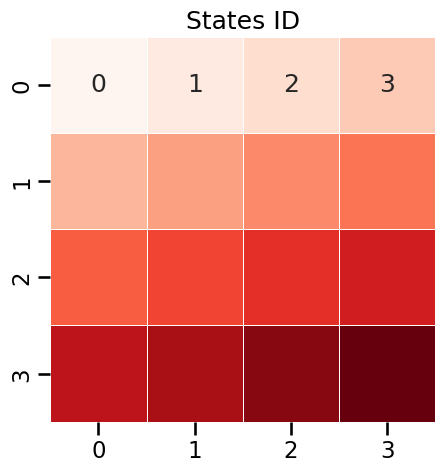

In [41]:
states_display(states, fmt="d", title="States ID")

The following plot shows the reward obtained in each square of the FrozenLake grid.

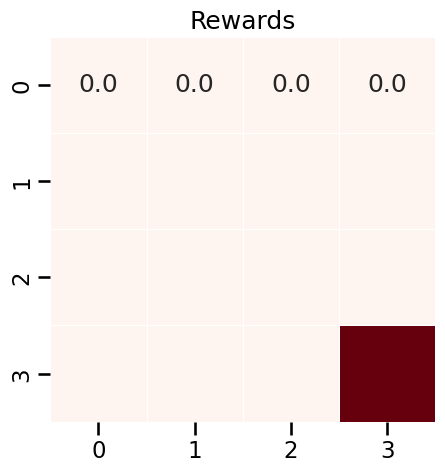

In [20]:
states_display(reward_array, title="Rewards")

The following plot shows whether a square is a final state or not (i.e. whether it ends the simulation or not).

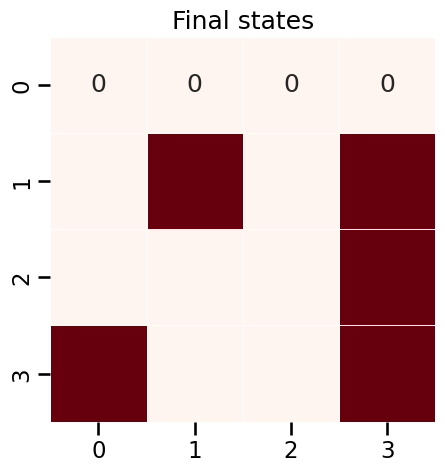

In [21]:
states_display(is_final_array, fmt="d", title="Final states")

The following cells show how to display transitions with the provided `transition_display` function. Figures displayed in squares are the probability to reach these squares from the given (`state`, `action`) pair. Colored squares are the states that may be reached from this pair (a non-zero probability).

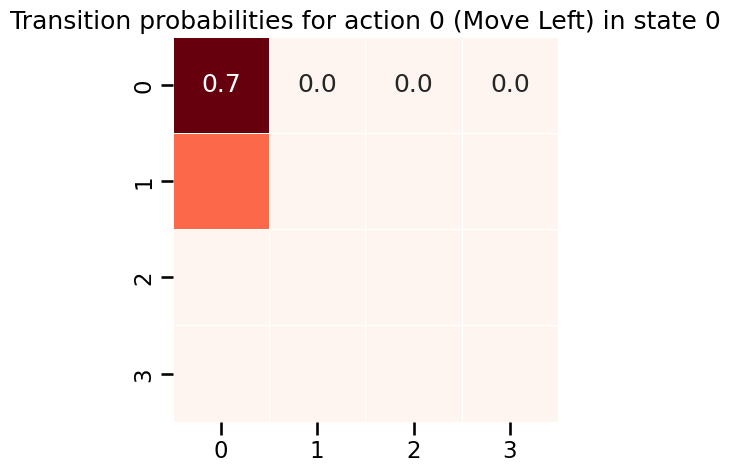

In [22]:
transition_display(state=0, action=0)

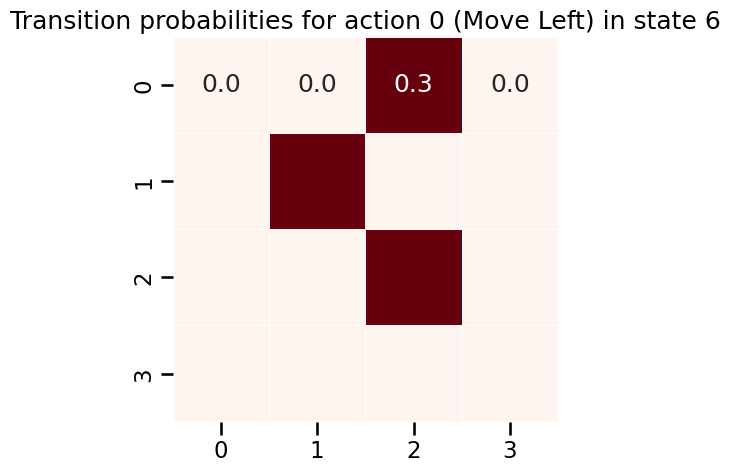

In [23]:
transition_display(state=6, action=0)

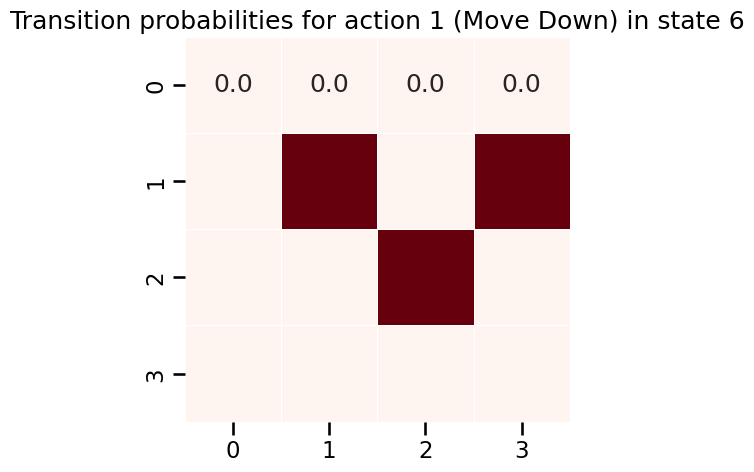

In [24]:
transition_display(state=6, action=1)

## Exercise 1: Implement the Value Iteration algorithm

To solve the FrozenLake-v1 problem with Dynamic Programming, we will first use the Value Iteration algorithm described in Algorithm 2.

Notice that the FrozenLake-v1 environment is non-deterministic.
To implement Value Iteration, you will need the transition probability (or the transition function) defined in `transition_array`.
- Use `reachable_states(S, A)` to get the list of reachable states from state `S` executing action `A`.
- Use `transition_array[S, A]` to get the probability of reaching each state from state `S` executing action `A`.
- Use `transition_array[S, A, S']` to get the probability of reaching state `S'` from state `S` executing action `A`.

You will also need the previously defined `is_final_array` matrix.
- Use `is_final_array[S]` to know whether `S` is a final state (`True`) or not (`False`).

Finally, you will need the previously defined `reward_array` matrix.
- Use `reward_array[S]` to get the reward obtained by the agent each time it reaches state `S`.

In the following cell, we define `expected_value` and `expected_values` functions for convenience.
The first one returns the expected reward
$$\sum P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V(\boldsymbol{s}')$$
for a given pair $(\boldsymbol{s}, \boldsymbol{a})$ and a given V-table (value function) $V$.
The second one computes the expected reward for all the actions in $\boldsymbol{s}$.

In [ ]:
## EXTRACT
def expected_value(state: int, action: int, v_array: np.ndarray) -> float:
    """
    Compute the expected value for a given state-action pair.

    Parameters
    ----------
    state : int
        The state from which the action is taken.
    action : int
        The action that is taken.
    v_array : np.ndarray
        The value function represented as a numpy array.

    Returns
    -------
    float
        The expected value for the given state-action pair.
    """
    # The transition_array is a global variable that contains the transition probabilities for each state-action pair.
    # The expected value for a state-action pair is computed as the sum of the product of the transition probabilities
    # and the values of the states. This is represented by the expression (transition_array[state, action] * v_array).sum().
    return (transition_array[state, action] * v_array).sum()  # compute sum(P(s'|a,s).V(s'))

In [ ]:
## EXTRACT
def expected_values(state: int, v_array: np.ndarray) -> np.ndarray:
    """
    Compute the expected values for all actions from a given state.

    Parameters
    ----------
    state : int
        The state from which the actions are taken.
    v_array : np.ndarray
        The value function represented as a numpy array.

    Returns
    -------
    np.ndarray
        A numpy array of expected values for all actions from the given state.
    """
    # The transition_array is a global variable that contains the transition probabilities for each state-action pair.
    # The expected values for all actions from a given state are computed as the sum of the product of the transition probabilities
    # and the values of the states. This is represented by the expression (transition_array[state] * v_array).sum(axis=1).
    # The axis=1 parameter means that the sum is computed over the second axis (i.e., for each action).
    return (transition_array[state] * v_array).sum(axis=1)   # compute sum(P(s'|a,s).V(s')) for all the actions

### Question 1: Implement the Value Iteration algorithm (compute the *value function* `v_array`)

**Note**: here we use the `state_display` function to show the evolution of the value function `v_array` over iterations.

In [ ]:
## EXTRACT Task 1

stop = False

def value_iteration(gamma: float = 0.95, epsilon: float = 0.001, display: bool = False) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    """
    Perform the value iteration algorithm for a given set of states and actions.

    Parameters
    ----------
    gamma : float, optional
        The discount factor, by default 0.95
    epsilon : float, optional
        The convergence threshold, by default 0.001
    display : bool, optional
        A flag indicating whether to display the value function at each iteration, by default False

    Returns
    -------
    np.ndarray
        The final value function after the value iteration algorithm has converged.
    List[np.ndarray]
        The history of the value function at each iteration.
    List[float]
        The history of the maximum change in the value function at each iteration.
    """
    # Initialize the history of the value function and the maximum change in the value function
    value_function_history = []
    delta_history = []

    # Initialize the value function with zeros
    v_array = np.zeros(len(states))
    stop = False

    # Continue the loop until the value function converges
    while not stop:
        # Display the value function if the display flag is set
        if display:
            states_display(v_array, title="Value function", cbar=True, cmap="Reds")
        else:
            print('.', end="")

        # Append the current value function to the history
        value_function_history.append(v_array)

        # Initialize the maximum change in the value function to zero
        delta = 0.

        # TODO...

        # Append the maximum change in the value function to the history
        delta_history.append(delta)

        # If the maximum change in the value function is less than the threshold, stop the loop
        if delta < epsilon:
            stop = True

    # Return the final value function, the history of the value function, and the history of the maximum change in the value function
    return v_array, value_function_history, delta_history

In [ ]:
v_array, value_function_history, delta_history = value_iteration(display=True)
states_display(v_array, title="Value function", cbar=True, cmap="Reds")

### Display the evolution of the value function over iterations

In [ ]:
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist

Evolution of `v_array` (the estimated value of each state) over iterations (one curve per state):

In [ ]:
df_v_hist.plot(figsize=(14,8))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(loc='upper right');

Evolution of `delta` over iterations:

In [ ]:
plt.plot(delta_history)
plt.yscale("log")
plt.title(r"$\max~\delta$ w.r.t iteration")
plt.ylabel(r"$\max~\delta$")
plt.xlabel("iteration");

### Question 2: Define the greedy policy (Maximum Expected Utility)

In [ ]:
## EXTRACT Task Greedy Policy
def greedy_policy(state: int, v_array: np.ndarray) -> int:
    """
    Compute the policy that maximizes the expected value for a given state.

    Parameters
    ----------
    state : int
        The state for which the policy is computed.
    v_array : np.ndarray
        The value function represented as a numpy array.

    Returns
    -------
    int
        The policy that maximizes the expected value for the given state.
    """

    # TODO...

    return policy

### Display the opimized policy

Applying the `greedy_policy` on each state gives us the policy matrix:

In [ ]:
policy = [greedy_policy(state, v_array) for state in states]

The following cell gives us a graphical representation of the optimal policy we have computed. The figure in each square is the optimal action to execute in the corresponding state (0 = "move left", 1 = "move down", 2 = "move right", 3 = "move up").

In [ ]:
display_policy(policy)

### Evaluate Value Iteration with Gymnasium (single trial)

So far, we have computed the value function `v_array` for one *episode*.
The environment is stochastic, thus if we apply the computed policy several times on the environment, we may have different results.
To measure the performance of our value function `v_array`, we should assess it several times and count the number of successful trials.
Gymnasium considers an agent to successfully solve the FrozenLake problem if it reaches 76% success rate over the last 100 trials (or "episodes").

In [ ]:
env._max_episode_steps = 1000

In [ ]:
reward_list = []

NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = env.reset()
    done = False
    #t = 0

    while not done:
        action = greedy_policy(state, v_array)
        state, reward, done, truncated, info = env.step(action)
        #t += 1

    reward_list.append(reward)
    #print("Episode finished after {} timesteps ; reward = {}".format(t, reward))

print(sum(reward_list) / NUM_EPISODES)

env.close()

### Question 3: What do you think the discount factor $\gamma$ is for?

TODO...

### Evaluate Value Iteration for different value of $\gamma$ with confidence interval (bootstrap)

In [ ]:
%%time

NUM_EPISODES = 1000

reward_list = []

for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    v_array, value_function_history, delta_history = value_iteration(gamma=gamma)

    for episode_index in range(NUM_EPISODES):
        state, info = env.reset()
        done = False

        while not done:
            action = greedy_policy(state, v_array)
            state, reward, done, truncated, info = env.step(action)

        reward_list.append({"gamma": gamma, "reward": reward})

env.close()

In [ ]:
df = pd.DataFrame(reward_list)
df.tail()

In [ ]:
# Plot mean reward (with its 95% confidence interval)

sns.relplot(x="gamma", y="reward", kind="line", data=df, height=6, aspect=1.5)
plt.axhline(0.76, color="red", linestyle=":", label="76% success threshold");   # 76% success threshold
plt.legend();

### Display the Value Iteration optimal policy with respect to $\gamma$

In [ ]:
for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    print()
    print("=" * 10, "GAMMA = ", gamma, "=" * 10)
    print()

    v_array, value_function_history, delta_history = value_iteration(gamma=gamma)

    print()
    print()

    policy = [greedy_policy(state, v_array) for state in states]
    display_policy(policy)

## Exercise 2: Implement the Policy Iteration algorithm

## Policy Iteration

*Policy Iteration* **[HOWARD60]** is another popular Dynamic Programming algorithm to
compute MDP's optimal policy. In practice, it is often faster than Value Iteration.

The Policy Iteration algorithm alternates the following two steps, starting with an initial policy $\pi_0$:
1. **Policy Evaluation**: given a policy $\pi_i$, compute $V^{\pi_i}(\boldsymbol{s}) ~ \forall \boldsymbol{s} \in \mathcal{S}$, the expected value of each state when $\pi_i$ is followed.
2. **Policy Improvement**: compute a new policy $\pi_{i+1}$, using one-step look-ahead based on $V^{\pi_i}$ and using the principle of *Maximum Expected Utility* as follows
$$
\pi_{i+1}(\boldsymbol{s}) = \arg \max_{\boldsymbol{a} \in \mathcal{A}} \sum_{\boldsymbol{s}'  \in \boldsymbol{s}space} P(\boldsymbol{s}'|\boldsymbol{s},\boldsymbol{a}) \left( r(\boldsymbol{s},\boldsymbol{a},\boldsymbol{s}') + \gamma V^{\pi_{i}}(\boldsymbol{s}') \right)
$$

In the following exercise we will assume that the reward only depends on the state: $r(\boldsymbol{s}) \equiv \mathcal{R}(\boldsymbol{s}, \boldsymbol{a}, \boldsymbol{s}')$.
Thus the *Policy Improvement* can be rewritten as follow:

$$
\pi_{i+1}(\boldsymbol{s}) = \arg\max_{\boldsymbol{a} \in \mathcal{A}} \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \boldsymbol{a}) V^{\pi_i}(\boldsymbol{s}')
$$

($r$ and $\gamma$ can disappear as they have no influence on the $\arg\max_{\boldsymbol{a}}$ result).

Algorithm 3 describes the two-step procedure.
The algorithm terminates when the *Policy Improvement* step yields no change in the utilities.

___
### Algorithm 3: Policy Iteration

**Input**:<br>
$\quad$ $MDP = \langle \mathcal{S}, \mathcal{A}, T, r \rangle$, a Markov Decision Process<br>
**Local variables**: <br>
$\quad$ $V$, vector of utilities for states in $\mathcal{S}$, initially zero <br>
$\quad$ $\pi$, a policy vector indexed by state, initially random <br>
<br>
**repeat** <br>
$\quad$ $V \leftarrow \text{POLICY-EVALUATION}(\pi, V, \text{MDP})$ <br>
$\quad$ unchanged $\leftarrow$ true <br>
$\quad$ **for all** state $\boldsymbol{s} \in \mathcal{S}$ **do** <br>
$\quad\quad$ **if** $\displaystyle \max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}'|\boldsymbol{s},\boldsymbol{a}) V[\boldsymbol{s}'] \right] > \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}' | \boldsymbol{s}, \pi_{i}(\boldsymbol{s})) V[\boldsymbol{s}']$ **then** <br>
$\quad\quad\quad$ $\displaystyle \pi[\boldsymbol{s}] \leftarrow \arg\max_{\boldsymbol{a} \in \mathcal{A}} \left[ \sum_{\boldsymbol{s}' \in \mathcal{S}} P(\boldsymbol{s}'|\boldsymbol{s},\boldsymbol{a}) V[\boldsymbol{s}'] \right]$ <br>
$\quad\quad\quad$ unchanged $\leftarrow$ false <br>
$\quad\quad$ **end if** <br>
$\quad$ **end for** <br>
**until** unchanged <br>
<br>
**return** $\pi$
___

Solving the POLICY-EVALUATION routine is much simpler than solving the standard
Bellman equations (which is what Value Iteration does).  Indeed, the action in each
state is fixed by the policy, thus the "max" operator disappears and Bellman
equations become linear.
As a result, $V^{\pi_i}$ can be computed by solving the linear system of these
*simplified Bellman equations* (Eq. 5) for
each state.

\begin{equation}
    V^{\pi_i}(\boldsymbol{s}) = \left\{
    \begin{array}{l l}
        r(\boldsymbol{s})               & \quad \text{if $\boldsymbol{s}$ is a final state} \\
        \displaystyle r(\boldsymbol{s}) + \gamma \sum_{\boldsymbol{s}' \in \boldsymbol{s}space} P(\boldsymbol{s}' | \boldsymbol{s}, \pi_{i}(\boldsymbol{s})) ~ V^{\pi_{i}}(\boldsymbol{s}')     & \quad \text{otherwise}\\
    \end{array} \right.
    \tag{5}
\end{equation}

### Convergence

As the number of states and policies is finite, and as the policy is improved
at each iteration, Policy Iteration converges in a finite number of iterations (often
small in practice).
However, within each iteration, solving the
POLICY-EVALUATION routine may cost a lot (its complexity is $O(|\mathcal{S}|^3)$).

An approach alternative to Value Iteration (Exercise 1) is Policy Iteration (described in Algorithm 3).

**Task:** implement Iterative Policy Iteration (for the same environment). Note that as part of this task you should also implement iterative policy evaluation. Compare the policies obtained by both approaches (they should be the same).

### Question 1: Define the (exact) Policy Evaluation function

In [ ]:
## EXTRACT Task Policy Evaluation
def policy_evaluation(policy: np.ndarray, gamma: float) -> np.ndarray:
    """
    Evaluate a policy by solving a system of linear equations.

    Parameters
    ----------
    policy : np.ndarray
        The policy to evaluate, represented as a numpy array.
    gamma : float
        The discount factor.

    Returns
    -------
    np.ndarray
        The value function for the given policy.
    """

    # TODO...

    # Return the solution x, which represents the value function for the given policy
    return x

### Question 2: Define the Policy Improvement function

In [ ]:
## EXTRACT Task Policy Iteration

def policy_iteration(
        gamma: float,
        initial_policy: Optional[np.ndarray] = None,
        policy_evaluation_function: Callable[[np.ndarray, float], np.ndarray] = policy_evaluation
) -> np.ndarray:
    """
    Perform the policy iteration algorithm for a given set of states and actions.

    Parameters
    ----------
    gamma : float
        The discount factor.
    initial_policy : np.ndarray, optional
        The initial policy, by default None. If None, a random initial policy is used.
    policy_evaluation_function : Callable[[np.ndarray, float], np.ndarray], optional
        The function to use for policy evaluation, by default policy_evaluation.

    Returns
    -------
    np.ndarray
        The optimal policy after the policy iteration algorithm has converged.
    """
    # TODO...

    # Return the final policy after the policy iteration algorithm has converged
    return policy

In [ ]:
gamma = 0.99

policy = policy_iteration(gamma=gamma, policy_evaluation_function=policy_evaluation)

display_policy(policy)

### Evaluate Policy Iteration with Gymnasium

In [ ]:
env._max_episode_steps = 1000

In [ ]:
reward_list = []

NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = env.reset()
    done = False
    #t = 0

    while not done:
        action = policy[state]
        state, reward, done, truncated, info = env.step(action)
        #t += 1

    reward_list.append(reward)
    #print("Episode finished after {} timesteps ; reward = {}".format(t, reward))

print(sum(reward_list) / NUM_EPISODES)

env.close()

### Evaluate Policy Iteration for different $\gamma$ with confidence interval (bootstrap)

In [ ]:
%%time

NUM_EPISODES = 1000

reward_list = []

for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.99):
    print("gamma:", gamma)
    policy = policy_iteration(gamma=gamma)

    for episode_index in range(NUM_EPISODES):
        state, info = env.reset()
        done = False

        while not done:
            action = policy[state]
            state, reward, done, truncated, info = env.step(action)

        reward_list.append({"gamma": gamma, "reward": reward})

env.close()

In [ ]:
df = pd.DataFrame(reward_list)
df.tail()

### Plot mean reward (with its 95% confidence interval)

In [ ]:
sns.relplot(x="gamma", y="reward", kind="line", data=df, height=6, aspect=1.5)
plt.axhline(0.76, color="red", linestyle=":", label="76% success threshold");   # 76% success threshold
plt.legend();

## References

**[BELLMAN57]** Richard Ernest Bellman. *Dynamic Programming*. Princeton University Press, Princeton,
New Jersey, USA, 1957.

**[HOWARD60]** R.A. Howard. Dynamic Programming and Markov Processes. MIT Press, Cambridge,
Massachusetts, 1960.

## Going further

In this lab we have introduced Reinforcement Learning in a very specific case where the *agent* (the algorithm) has a perfect knowledge of the environment (transition and reward functions).

This is convenient to introduce basic concepts but we cannot expect this assumption to be true in many practical problems.
A lot of sophisticated algorithms have been developed recently and most of them have been implemented in [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) library and can be used in [Gymnasium](https://gymnasium.farama.org/) benchmark library.

Also, for those who want to go further, one of the best book in reinforcement learning is freely available on the web: http://incompleteideas.net/book/RLbook2018.pdf

Example of what can be done in RL:
- AlphaGo (movie) https://www.youtube.com/watch?v=WXuK6gekU1Y (this work had huge impact in the AI community)
- AlphaGo https://deepmind.com/research/case-studies/alphago-the-story-so-far
- AlphaZero https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go
- AlphaStar (StarCraft II) https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
- DQN https://deepmind.com/blog/article/deep-reinforcement-learning
- Dota 2 https://openai.com/blog/openai-five/
- Robotics https://openai.com/blog/solving-rubiks-cube/
- Robotics https://openai.com/blog/learning-dexterity/
- Breakout https://www.youtube.com/watch?v=V1eYniJ0Rnk
- Walker https://youtu.be/pgaEE27nsQw
- Helicopter https://www.youtube.com/watch?v=VCdxqn0fcnE
- Energy https://deepmind.com/blog/article/deepmind-ai-reduces-google-data-centre-cooling-bill-40
- Self-driving cars